In [155]:
import tensorflow as tf

print(tf.__version__)

2.10.0


In [156]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
print("Ïäù=3")

Ïäù=3


In [157]:
# Ìè¨ÏßÄÏÖîÎÑê Ïù∏ÏΩîÎî© Î†àÏù¥Ïñ¥
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
        self.position = position
        self.d_model = d_model

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            'position': self.position,
            'd_model': self.d_model
        })
        return config

    def positional_encoding(self, position, d_model):
        # Í∞ÅÎèÑ Î∞∞Ïó¥ ÏÉùÏÑ±
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # Î∞∞Ïó¥Ïùò ÏßùÏàò Ïù∏Îç±Ïä§ÏóêÎäî sin Ìï®Ïàò Ï†ÅÏö©
        sines = tf.math.sin(angle_rads[:, 0::2])
        # Î∞∞Ïó¥Ïùò ÌôÄÏàò Ïù∏Îç±Ïä§ÏóêÎäî cosine Ìï®Ïàò Ï†ÅÏö©
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sinÍ≥º cosineÏù¥ ÍµêÏ∞®ÎêòÎèÑÎ°ù Ïû¨Î∞∞Ïó¥
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("Ïäù=3")

Ïäù=3


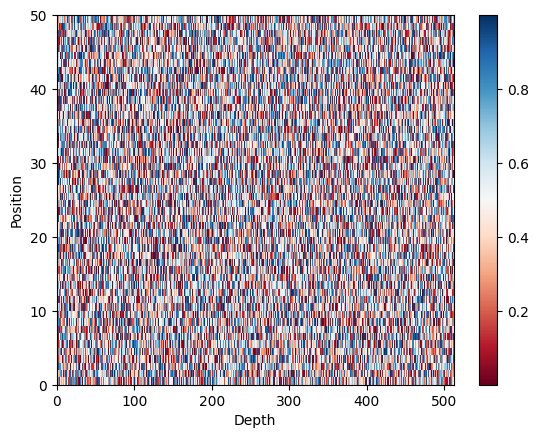

In [158]:
sample_pos_encoding = np.random.rand(50, 512)

plt.pcolormesh(sample_pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [159]:
# Ïä§ÏºÄÏùºÎìú Îã∑ ÌîÑÎ°úÎçïÌä∏ Ïñ¥ÌÖêÏÖò Ìï®Ïàò
def scaled_dot_product_attention(query, key, value, mask):
  # Ïñ¥ÌÖêÏÖò Í∞ÄÏ§ëÏπòÎäî QÏôÄ KÏùò Îã∑ ÌîÑÎ°úÎçïÌä∏
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # Í∞ÄÏ§ëÏπòÎ•º Ï†ïÍ∑úÌôî
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # Ìå®Îî©Ïóê ÎßàÏä§ÌÅ¨ Ï∂îÍ∞Ä
  if mask is not None:
    logits += (mask * -1e9)

  # softmaxÏ†ÅÏö©
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # ÏµúÏ¢Ö Ïñ¥ÌÖêÏÖòÏùÄ Í∞ÄÏ§ëÏπòÏôÄ VÏùò Îã∑ ÌîÑÎ°úÎçïÌä∏
  output = tf.matmul(attention_weights, value)
  return output

print("Ïäù=3")

Ïäù=3


In [160]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)
    
    def get_config(self):
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            'd_model': self.d_model,
            'num_heads': self.num_heads
        })
        return config

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, VÏóê Í∞ÅÍ∞Å DenseÎ•º Ï†ÅÏö©Ìï©ÎãàÎã§
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Î≥ëÎ†¨ Ïó∞ÏÇ∞ÏùÑ ÏúÑÌïú Î®∏Î¶¨Î•º Ïó¨Îü¨ Í∞ú ÎßåÎì≠ÎãàÎã§
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # Ïä§ÏºÄÏùºÎìú Îã∑ ÌîÑÎ°úÎçïÌä∏ Ïñ¥ÌÖêÏÖò Ìï®Ïàò
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # Ïñ¥ÌÖêÏÖò Ïó∞ÏÇ∞ ÌõÑÏóê Í∞Å Í≤∞Í≥ºÎ•º Îã§Ïãú Ïó∞Í≤∞(concatenate)Ìï©ÎãàÎã§
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # ÏµúÏ¢Ö Í≤∞Í≥ºÏóêÎèÑ DenseÎ•º Ìïú Î≤à Îçî Ï†ÅÏö©Ìï©ÎãàÎã§
        outputs = self.dense(concat_attention)

        return outputs
print("Ïäù=3")

Ïäù=3


In [161]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("Ïäù=3")

Ïäù=3


In [162]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("Ïäù=3")

Ïäù=3


In [163]:
# Ïù∏ÏΩîÎçî ÌïòÎÇòÏùò Î†àÏù¥Ïñ¥Î•º Ìï®ÏàòÎ°ú Íµ¨ÌòÑ.
# Ïù¥ ÌïòÎÇòÏùò Î†àÏù¥Ïñ¥ ÏïàÏóêÎäî Îëê Í∞úÏùò ÏÑúÎ∏å Î†àÏù¥Ïñ¥Í∞Ä Ï°¥Ïû¨Ìï©ÎãàÎã§.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # Ìå®Îî© ÎßàÏä§ÌÅ¨ ÏÇ¨Ïö©
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # Ï≤´ Î≤àÏß∏ ÏÑúÎ∏å Î†àÏù¥Ïñ¥ : Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖò ÏàòÌñâ (ÏÖÄÌîÑ Ïñ¥ÌÖêÏÖò)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # Ïñ¥ÌÖêÏÖòÏùò Í≤∞Í≥ºÎäî DropoutÍ≥º Layer NormalizationÏù¥ÎùºÎäî ÌõàÎ†®ÏùÑ ÎèïÎäî ÌÖåÌÅ¨ÎãâÏùÑ ÏàòÌñâ
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # Îëê Î≤àÏß∏ ÏÑúÎ∏å Î†àÏù¥Ïñ¥ : 2Í∞úÏùò ÏôÑÏ†ÑÏó∞Í≤∞Ï∏µ
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # ÏôÑÏ†ÑÏó∞Í≤∞Ï∏µÏùò Í≤∞Í≥ºÎäî DropoutÍ≥º LayerNormalizationÏù¥ÎùºÎäî ÌõàÎ†®ÏùÑ ÎèïÎäî ÌÖåÌÅ¨ÎãâÏùÑ ÏàòÌñâ
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("Ïäù=3")

Ïäù=3


In [164]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # Ìå®Îî© ÎßàÏä§ÌÅ¨ ÏÇ¨Ïö©
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # ÏûÑÎ≤†Îî© Î†àÏù¥Ïñ¥
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # Ìè¨ÏßÄÏÖîÎÑê Ïù∏ÏΩîÎî©
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layersÎßåÌÅº ÏåìÏïÑÏò¨Î¶∞ Ïù∏ÏΩîÎçîÏùò Ï∏µ.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("Ïäù=3")

Ïäù=3


In [165]:
# ÎîîÏΩîÎçî ÌïòÎÇòÏùò Î†àÏù¥Ïñ¥Î•º Ìï®ÏàòÎ°ú Íµ¨ÌòÑ.
# Ïù¥ ÌïòÎÇòÏùò Î†àÏù¥Ïñ¥ ÏïàÏóêÎäî ÏÑ∏ Í∞úÏùò ÏÑúÎ∏å Î†àÏù¥Ïñ¥Í∞Ä Ï°¥Ïû¨Ìï©ÎãàÎã§.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # Ï≤´ Î≤àÏß∏ ÏÑúÎ∏å Î†àÏù¥Ïñ¥ : Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖò ÏàòÌñâ (ÏÖÄÌîÑ Ïñ¥ÌÖêÏÖò)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖòÏùò Í≤∞Í≥ºÎäî LayerNormalizationÏù¥ÎùºÎäî ÌõàÎ†®ÏùÑ ÎèïÎäî ÌÖåÌÅ¨ÎãâÏùÑ ÏàòÌñâ
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # Îëê Î≤àÏß∏ ÏÑúÎ∏å Î†àÏù¥Ïñ¥ : ÎßàÏä§ÌÅ¨Îìú Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖò ÏàòÌñâ (Ïù∏ÏΩîÎçî-ÎîîÏΩîÎçî Ïñ¥ÌÖêÏÖò)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # ÎßàÏä§ÌÅ¨Îìú Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖòÏùò Í≤∞Í≥ºÎäî
  # DropoutÍ≥º LayerNormalizationÏù¥ÎùºÎäî ÌõàÎ†®ÏùÑ ÎèïÎäî ÌÖåÌÅ¨ÎãâÏùÑ ÏàòÌñâ
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # ÏÑ∏ Î≤àÏß∏ ÏÑúÎ∏å Î†àÏù¥Ïñ¥ : 2Í∞úÏùò ÏôÑÏ†ÑÏó∞Í≤∞Ï∏µ
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # ÏôÑÏ†ÑÏó∞Í≤∞Ï∏µÏùò Í≤∞Í≥ºÎäî DropoutÍ≥º LayerNormalization ÏàòÌñâ
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("Ïäù=3")

Ïäù=3


In [166]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # Ìå®Îî© ÎßàÏä§ÌÅ¨
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # ÏûÑÎ≤†Îî© Î†àÏù¥Ïñ¥
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # Ìè¨ÏßÄÏÖîÎÑê Ïù∏ÏΩîÎî©
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # DropoutÏù¥ÎùºÎäî ÌõàÎ†®ÏùÑ ÎèïÎäî ÌÖåÌÅ¨ÎãâÏùÑ ÏàòÌñâ
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("Ïäù=3")

Ïäù=3


In [167]:
path_to_ChatbotData = os.path.join(r'C:\Users\YJKIM_PC\aiffel\transformer_chatbot\data', 'ChatbotData.csv')
print("Ïäù=3")

Ïäù=3


In [168]:
# ÏÇ¨Ïö©Ìï† ÏÉòÌîåÏùò ÏµúÎåÄ Í∞úÏàò
MAX_SAMPLES = 20000
print(MAX_SAMPLES)

20000


In [169]:
# Ï†ÑÏ≤òÎ¶¨ Ìï®Ïàò
def preprocess_sentence(sentence):    

  # Îã®Ïñ¥ÏôÄ Íµ¨ÎëêÏ†ê(punctuation) ÏÇ¨Ïù¥Ïùò Í±∞Î¶¨Î•º ÎßåÎì≠ÎãàÎã§.
  # ÏòàÎ•º Îì§Ïñ¥ÏÑú "I am a student." => "I am a student ."ÏôÄ Í∞ôÏù¥
  # studentÏôÄ Ïò®Ï†ê ÏÇ¨Ïù¥Ïóê Í±∞Î¶¨Î•º ÎßåÎì≠ÎãàÎã§.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",")Î•º Ï†úÏô∏Ìïú Î™®Îì† Î¨∏ÏûêÎ•º Í≥µÎ∞±Ïù∏ ' 'Î°ú ÎåÄÏ≤¥Ìï©ÎãàÎã§.
    sentence = re.sub(r'[^„Ñ±-„ÖéÍ∞Ä-Ìû£a-zA-Z0-9.!?,\s]', ' ', sentence)
    sentence = sentence.strip()
    return sentence
print("Ïäù=3")

Ïäù=3


In [170]:
# ÏßàÎ¨∏Í≥º ÎãµÎ≥ÄÏùò ÏåçÏù∏ Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Íµ¨ÏÑ±ÌïòÍ∏∞ ÏúÑÌïú Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ìï®Ïàò
def load_conversations(path_to_ChatbotData, MAX_SAMPLES):
    inputs, outputs = [], []
    with open(path_to_ChatbotData, 'r', encoding='cp949') as file:
        next(file)
        lines = file.readlines()
        
    for line in lines:
        parts = line.strip().split(',')
        
        if len(parts) >=2:
            question, answer = parts[0], parts[1]
            
            inputs.append(preprocess_sentence(question))
            outputs.append(preprocess_sentence(answer))
            
            if len(inputs) >= MAX_SAMPLES:
                break

    return inputs, outputs
print("Ïäù=3")

Ïäù=3


In [171]:
# Îç∞Ïù¥ÌÑ∞Î•º Î°úÎìúÌïòÍ≥† Ï†ÑÏ≤òÎ¶¨ÌïòÏó¨ ÏßàÎ¨∏ÏùÑ questions, ÎãµÎ≥ÄÏùÑ answersÏóê Ï†ÄÏû•Ìï©ÎãàÎã§.
questions, answers = load_conversations(path_to_ChatbotData, MAX_SAMPLES)
print('Ï†ÑÏ≤¥ ÏÉòÌîå Ïàò :', len(questions))
print('Ï†ÑÏ≤¥ ÏÉòÌîå Ïàò :', len(answers))

Ï†ÑÏ≤¥ ÏÉòÌîå Ïàò : 11823
Ï†ÑÏ≤¥ ÏÉòÌîå Ïàò : 11823


In [172]:
print('Ï†ÑÏ≤òÎ¶¨ ÌõÑÏùò 22Î≤àÏß∏ ÏßàÎ¨∏ ÏÉòÌîå: {}'.format(questions[21]))
print('Ï†ÑÏ≤òÎ¶¨ ÌõÑÏùò 22Î≤àÏß∏ ÎãµÎ≥Ä ÏÉòÌîå: {}'.format(answers[21]))

Ï†ÑÏ≤òÎ¶¨ ÌõÑÏùò 22Î≤àÏß∏ ÏßàÎ¨∏ ÏÉòÌîå: Í∞ÄÏä§ÎπÑ Ïû•ÎÇú ÏïÑÎãò
Ï†ÑÏ≤òÎ¶¨ ÌõÑÏùò 22Î≤àÏß∏ ÎãµÎ≥Ä ÏÉòÌîå: Îã§Ïùå Îã¨ÏóêÎäî Îçî Ï†àÏïΩÌï¥Î¥êÏöî .


In [173]:
import tensorflow_datasets as tfds
print("ÏÇ¥Ïßù Ïò§Îûò Í±∏Î¶¥ Ïàò ÏûàÏñ¥Ïöî. Ïä§Ìä∏Î†àÏπ≠ Ìïú Î≤à Ìï¥Î≥ºÍπåÏöî? üëê")

# ÏßàÎ¨∏Í≥º ÎãµÎ≥Ä Îç∞Ïù¥ÌÑ∞ÏÖãÏóê ÎåÄÌï¥ÏÑú Vocabulary ÏÉùÏÑ±
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("Ïäù=3 ")

ÏÇ¥Ïßù Ïò§Îûò Í±∏Î¶¥ Ïàò ÏûàÏñ¥Ïöî. Ïä§Ìä∏Î†àÏπ≠ Ìïú Î≤à Ìï¥Î≥ºÍπåÏöî? üëê
Ïäù=3 


In [174]:
# ÏãúÏûë ÌÜ†ÌÅ∞Í≥º Ï¢ÖÎ£å ÌÜ†ÌÅ∞Ïóê Í≥†Ïú†Ìïú Ï†ïÏàòÎ•º Î∂ÄÏó¨Ìï©ÎãàÎã§.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("Ïäù=3")

Ïäù=3


In [175]:
print('START_TOKENÏùò Î≤àÌò∏ :' ,[tokenizer.vocab_size])
print('END_TOKENÏùò Î≤àÌò∏ :' ,[tokenizer.vocab_size + 1])

START_TOKENÏùò Î≤àÌò∏ : [8143]
END_TOKENÏùò Î≤àÌò∏ : [8144]


In [176]:
# ÏãúÏûë ÌÜ†ÌÅ∞Í≥º Ï¢ÖÎ£å ÌÜ†ÌÅ∞ÏùÑ Í≥†Î†§ÌïòÏó¨ +2Î•º ÌïòÏó¨ Îã®Ïñ¥Ïû•Ïùò ÌÅ¨Í∏∞Î•º ÏÇ∞Ï†ïÌï©ÎãàÎã§.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8145


In [177]:
# ÏûÑÏùòÏùò 22Î≤àÏß∏ ÏÉòÌîåÏóê ÎåÄÌï¥ÏÑú Ï†ïÏàò Ïù∏ÏΩîÎî© ÏûëÏóÖÏùÑ ÏàòÌñâ.
# Í∞Å ÌÜ†ÌÅ∞ÏùÑ Í≥†Ïú†Ìïú Ï†ïÏàòÎ°ú Î≥ÄÌôò
print('Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑÏùò 21Î≤àÏß∏ ÏßàÎ¨∏ ÏÉòÌîå: {}'.format(tokenizer.encode(questions[21])))
print('Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑÏùò 21Î≤àÏß∏ ÎãµÎ≥Ä ÏÉòÌîå: {}'.format(tokenizer.encode(answers[21])))

Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑÏùò 21Î≤àÏß∏ ÏßàÎ¨∏ ÏÉòÌîå: [5741, 607, 2480, 4141]
Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑÏùò 21Î≤àÏß∏ ÎãµÎ≥Ä ÏÉòÌîå: [2346, 7487, 7, 6251, 95, 1]


In [178]:
# ÏÉòÌîåÏùò ÏµúÎåÄ ÌóàÏö© Í∏∏Ïù¥ ÎòêÎäî Ìå®Îî© ÌõÑÏùò ÏµúÏ¢Ö Í∏∏Ïù¥
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [179]:
# Ï†ïÏàò Ïù∏ÏΩîÎî©, ÏµúÎåÄ Í∏∏Ïù¥Î•º Ï¥àÍ≥ºÌïòÎäî ÏÉòÌîå Ï†úÍ±∞, Ìå®Îî©
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # Ï†ïÏàò Ïù∏ÏΩîÎî© Í≥ºÏ†ïÏóêÏÑú ÏãúÏûë ÌÜ†ÌÅ∞Í≥º Ï¢ÖÎ£å ÌÜ†ÌÅ∞ÏùÑ Ï∂îÍ∞Ä
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # ÏµúÎåÄ Í∏∏Ïù¥ 40 Ïù¥ÌïòÏù∏ Í≤ΩÏö∞ÏóêÎßå Îç∞Ïù¥ÌÑ∞ÏÖãÏúºÎ°ú ÌóàÏö©
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # ÏµúÎåÄ Í∏∏Ïù¥ 40ÏúºÎ°ú Î™®Îì† Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Ìå®Îî©
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("Ïäù=3")

Ïäù=3


In [180]:
questions, answers = tokenize_and_filter(questions, answers)
print('Îã®Ïñ¥Ïû•Ïùò ÌÅ¨Í∏∞ :',(VOCAB_SIZE))
print('ÌïÑÌÑ∞ÎßÅ ÌõÑÏùò ÏßàÎ¨∏ ÏÉòÌîå Í∞úÏàò: {}'.format(len(questions)))
print('ÌïÑÌÑ∞ÎßÅ ÌõÑÏùò ÎãµÎ≥Ä ÏÉòÌîå Í∞úÏàò: {}'.format(len(answers)))

Îã®Ïñ¥Ïû•Ïùò ÌÅ¨Í∏∞ : 8145
ÌïÑÌÑ∞ÎßÅ ÌõÑÏùò ÏßàÎ¨∏ ÏÉòÌîå Í∞úÏàò: 11823
ÌïÑÌÑ∞ÎßÅ ÌõÑÏùò ÎãµÎ≥Ä ÏÉòÌîå Í∞úÏàò: 11823


In [181]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# ÎîîÏΩîÎçîÎäî Ïù¥Ï†ÑÏùò targetÏùÑ Îã§ÏùåÏùò inputÏúºÎ°ú ÏÇ¨Ïö©Ìï©ÎãàÎã§.
# Ïù¥Ïóê Îî∞Îùº outputsÏóêÏÑúÎäî START_TOKENÏùÑ Ï†úÍ±∞ÌïòÍ≤†ÏäµÎãàÎã§.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("Ïäù=3")

Ïäù=3


In [182]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # Ïù∏ÏΩîÎçîÏóêÏÑú Ìå®Îî©ÏùÑ ÏúÑÌïú ÎßàÏä§ÌÅ¨
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # ÎîîÏΩîÎçîÏóêÏÑú ÎØ∏ÎûòÏùò ÌÜ†ÌÅ∞ÏùÑ ÎßàÏä§ÌÅ¨ ÌïòÍ∏∞ ÏúÑÌï¥ÏÑú ÏÇ¨Ïö©Ìï©ÎãàÎã§.
  # ÎÇ¥Î∂ÄÏ†ÅÏúºÎ°ú Ìå®Îî© ÎßàÏä§ÌÅ¨ÎèÑ Ìè¨Ìï®ÎêòÏñ¥Ï†∏ ÏûàÏäµÎãàÎã§.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # Îëê Î≤àÏß∏ Ïñ¥ÌÖêÏÖò Î∏îÎ°ùÏóêÏÑú Ïù∏ÏΩîÎçîÏùò Î≤°ÌÑ∞Îì§ÏùÑ ÎßàÏä§ÌÇπ
  # ÎîîÏΩîÎçîÏóêÏÑú Ìå®Îî©ÏùÑ ÏúÑÌïú ÎßàÏä§ÌÅ¨
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # Ïù∏ÏΩîÎçî
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # ÎîîÏΩîÎçî
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # ÏôÑÏ†ÑÏó∞Í≤∞Ï∏µ
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("Ïäù=3")

Ïäù=3


In [183]:
tf.keras.backend.clear_session()

# ÌïòÏù¥ÌçºÌååÎùºÎØ∏ÌÑ∞
NUM_LAYERS = 4 # Ïù∏ÏΩîÎçîÏôÄ ÎîîÏΩîÎçîÏùò Ï∏µÏùò Í∞úÏàò
D_MODEL = 256 # Ïù∏ÏΩîÎçîÏôÄ ÎîîÏΩîÎçî ÎÇ¥Î∂ÄÏùò ÏûÖ, Ï∂úÎ†•Ïùò Í≥†Ï†ï Ï∞®Ïõê
NUM_HEADS = 8 # Î©ÄÌã∞ Ìó§Îìú Ïñ¥ÌÖêÏÖòÏóêÏÑúÏùò Ìó§Îìú Ïàò 
UNITS = 512 # ÌîºÎìú Ìè¨ÏõåÎìú Ïã†Í≤ΩÎßùÏùò ÏùÄÎãâÏ∏µÏùò ÌÅ¨Í∏∞
DROPOUT = 0.1 # ÎìúÎ°≠ÏïÑÏõÉÏùò ÎπÑÏú®

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    4193536     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

In [184]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("Ïäù=3")

Ïäù=3


In [191]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
    def get_config(self):
        return {
            "d_model": self.d_model.numpy(),  # Ensure this is a plain Python type, not a Tensor
            "warmup_steps": self.warmup_steps
        }
    
print("Ïäù=3")

Ïäù=3


Text(0.5, 0, 'Train Step')

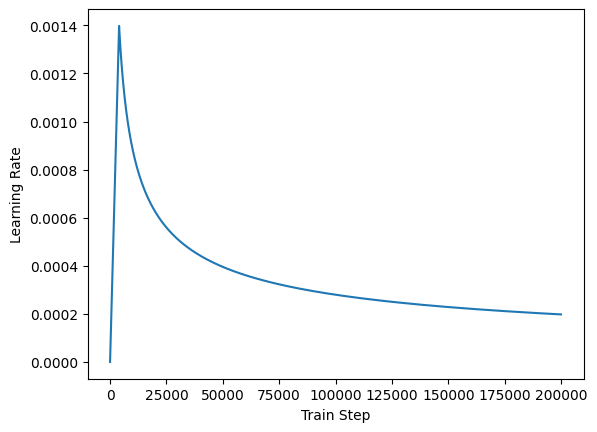

In [192]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [193]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("Ïäù=3")

Ïäù=3


In [194]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='accuracy', patience=7, restore_best_weights=True)

In [195]:
from keras.callbacks import ModelCheckpoint

# ModelCheckpoint Í∞ùÏ≤¥Î•º ÏÉùÏÑ±Ìï©ÎãàÎã§.
checkpoint = ModelCheckpoint("weights.h5", monitor='accuracy', verbose=1, save_best_only=True)

In [196]:
EPOCHS = 100
model.fit(dataset, epochs=EPOCHS, verbose=1, callbacks=[early_stopping, checkpoint])

Epoch 1/100
185/185 [==============================] - ETA: 0s - loss: 1.2587 - accuracy: 0.0489
Epoch 1: accuracy improved from -inf to 0.04892, saving model to weights.h5
185/185 [==============================] - 23s 72ms/step - loss: 1.2587 - accuracy: 0.0489
Epoch 2/100
185/185 [==============================] - ETA: 0s - loss: 1.0923 - accuracy: 0.0494
Epoch 2: accuracy improved from 0.04892 to 0.04942, saving model to weights.h5
185/185 [==============================] - 13s 72ms/step - loss: 1.0923 - accuracy: 0.0494
Epoch 3/100
185/185 [==============================] - ETA: 0s - loss: 0.9787 - accuracy: 0.0507
Epoch 3: accuracy improved from 0.04942 to 0.05071, saving model to weights.h5
185/185 [==============================] - 14s 75ms/step - loss: 0.9787 - accuracy: 0.0507
Epoch 4/100
185/185 [==============================] - ETA: 0s - loss: 0.9252 - accuracy: 0.0540
Epoch 4: accuracy improved from 0.05071 to 0.05404, saving model to weights.h5
185/185 [=================

In [197]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # ÏûÖÎ†•Îêú Î¨∏Ïû•ÏùÑ Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑ, ÏãúÏûë ÌÜ†ÌÅ∞Í≥º Ï¢ÖÎ£å ÌÜ†ÌÅ∞ÏùÑ ÏïûÎí§Î°ú Ï∂îÍ∞Ä.
  # ex) Where have you been? ‚Üí [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # ÎîîÏΩîÎçîÏùò ÌòÑÏû¨ÍπåÏßÄÏùò ÏòàÏ∏°Ìïú Ï∂úÎ†• ÏãúÌÄÄÏä§Í∞Ä ÏßÄÏÜçÏ†ÅÏúºÎ°ú Ï†ÄÏû•ÎêòÎäî Î≥ÄÏàò.
  # Ï≤òÏùåÏóêÎäî ÏòàÏ∏°Ìïú ÎÇ¥Ïö©Ïù¥ ÏóÜÏùåÏúºÎ°ú ÏãúÏûë ÌÜ†ÌÅ∞Îßå Î≥ÑÎèÑ Ï†ÄÏû•. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # ÎîîÏΩîÎçîÏùò Ïù∏ÌçºÎü∞Ïä§ Îã®Í≥Ñ
  for i in range(MAX_LENGTH):
    # ÎîîÏΩîÎçîÎäî ÏµúÎåÄ MAX_LENGTHÏùò Í∏∏Ïù¥ÎßåÌÅº Îã§Ïùå Îã®Ïñ¥ ÏòàÏ∏°ÏùÑ Î∞òÎ≥µÌï©ÎãàÎã§.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # ÌòÑÏû¨ ÏòàÏ∏°Ìïú Îã®Ïñ¥Ïùò Ï†ïÏàò
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # ÎßåÏïΩ ÌòÑÏû¨ ÏòàÏ∏°Ìïú Îã®Ïñ¥Í∞Ä Ï¢ÖÎ£å ÌÜ†ÌÅ∞Ïù¥ÎùºÎ©¥ forÎ¨∏ÏùÑ Ï¢ÖÎ£å
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # ÏòàÏ∏°Ìïú Îã®Ïñ¥Îì§ÏùÄ ÏßÄÏÜçÏ†ÅÏúºÎ°ú output_sequenceÏóê Ï∂îÍ∞ÄÎê©ÎãàÎã§.
    # Ïù¥ output_sequenceÎäî Îã§Ïãú ÎîîÏΩîÎçîÏùò ÏûÖÎ†•Ïù¥ Îê©ÎãàÎã§.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("Ïäù=3")

Ïäù=3


In [198]:
def sentence_generation(sentence):
  # ÏûÖÎ†• Î¨∏Ïû•Ïóê ÎåÄÌï¥ÏÑú ÎîîÏΩîÎçîÎ•º ÎèôÏûë ÏãúÏºú ÏòàÏ∏°Îêú Ï†ïÏàò ÏãúÌÄÄÏä§Î•º Î¶¨ÌÑ¥Î∞õÏäµÎãàÎã§.
  prediction = decoder_inference(sentence)

  # Ï†ïÏàò ÏãúÌÄÄÏä§Î•º Îã§Ïãú ÌÖçÏä§Ìä∏ ÏãúÌÄÄÏä§Î°ú Î≥ÄÌôòÌï©ÎãàÎã§.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('ÏûÖÎ†• : {}'.format(sentence))
  print('Ï∂úÎ†• : {}'.format(predicted_sentence))

  return predicted_sentence
print("Ïäù=3")

Ïäù=3


In [201]:
sentence_generation('ÏöîÏ¶ò ÎÑàÎ¨¥ ÌñâÎ≥µÌï¥!')

ÏûÖÎ†• : ÏöîÏ¶ò ÎÑàÎ¨¥ ÌñâÎ≥µÌï¥!
Ï∂úÎ†• : Ïù∏ÏÉùÏùÑ ÏïåÏïÑÍ∞ÄÍ≥† ÏûàÍµ∞Ïöî .


'Ïù∏ÏÉùÏùÑ ÏïåÏïÑÍ∞ÄÍ≥† ÏûàÍµ∞Ïöî .'

In [202]:
model.load_weights("weights.h5")

In [203]:
EPOCHS = 100
model.fit(dataset, epochs=EPOCHS, verbose=1, callbacks=[early_stopping, checkpoint])

Epoch 1/100
185/185 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 0.1733
Epoch 1: accuracy improved from 0.17323 to 0.17330, saving model to weights.h5
185/185 [==============================] - 13s 71ms/step - loss: 0.0037 - accuracy: 0.1733
Epoch 2/100
185/185 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 0.1733
Epoch 2: accuracy did not improve from 0.17330
185/185 [==============================] - 13s 70ms/step - loss: 0.0037 - accuracy: 0.1733
Epoch 3/100
185/185 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.1733
Epoch 3: accuracy did not improve from 0.17330
185/185 [==============================] - 13s 70ms/step - loss: 0.0036 - accuracy: 0.1733
Epoch 4/100
185/185 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 0.1732
Epoch 4: accuracy did not improve from 0.17330
185/185 [==============================] - 13s 70ms/step - loss: 0.0035 - accuracy: 0.1732
Epoch 5/100
185/185 [=======

In [204]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # ÏûÖÎ†•Îêú Î¨∏Ïû•ÏùÑ Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑ, ÏãúÏûë ÌÜ†ÌÅ∞Í≥º Ï¢ÖÎ£å ÌÜ†ÌÅ∞ÏùÑ ÏïûÎí§Î°ú Ï∂îÍ∞Ä.
  # ex) Where have you been? ‚Üí [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # ÎîîÏΩîÎçîÏùò ÌòÑÏû¨ÍπåÏßÄÏùò ÏòàÏ∏°Ìïú Ï∂úÎ†• ÏãúÌÄÄÏä§Í∞Ä ÏßÄÏÜçÏ†ÅÏúºÎ°ú Ï†ÄÏû•ÎêòÎäî Î≥ÄÏàò.
  # Ï≤òÏùåÏóêÎäî ÏòàÏ∏°Ìïú ÎÇ¥Ïö©Ïù¥ ÏóÜÏùåÏúºÎ°ú ÏãúÏûë ÌÜ†ÌÅ∞Îßå Î≥ÑÎèÑ Ï†ÄÏû•. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # ÎîîÏΩîÎçîÏùò Ïù∏ÌçºÎü∞Ïä§ Îã®Í≥Ñ
  for i in range(MAX_LENGTH):
    # ÎîîÏΩîÎçîÎäî ÏµúÎåÄ MAX_LENGTHÏùò Í∏∏Ïù¥ÎßåÌÅº Îã§Ïùå Îã®Ïñ¥ ÏòàÏ∏°ÏùÑ Î∞òÎ≥µÌï©ÎãàÎã§.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # ÌòÑÏû¨ ÏòàÏ∏°Ìïú Îã®Ïñ¥Ïùò Ï†ïÏàò
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # ÎßåÏïΩ ÌòÑÏû¨ ÏòàÏ∏°Ìïú Îã®Ïñ¥Í∞Ä Ï¢ÖÎ£å ÌÜ†ÌÅ∞Ïù¥ÎùºÎ©¥ forÎ¨∏ÏùÑ Ï¢ÖÎ£å
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # ÏòàÏ∏°Ìïú Îã®Ïñ¥Îì§ÏùÄ ÏßÄÏÜçÏ†ÅÏúºÎ°ú output_sequenceÏóê Ï∂îÍ∞ÄÎê©ÎãàÎã§.
    # Ïù¥ output_sequenceÎäî Îã§Ïãú ÎîîÏΩîÎçîÏùò ÏûÖÎ†•Ïù¥ Îê©ÎãàÎã§.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("Ïäù=3")

Ïäù=3


In [205]:
def sentence_generation(sentence):
  # ÏûÖÎ†• Î¨∏Ïû•Ïóê ÎåÄÌï¥ÏÑú ÎîîÏΩîÎçîÎ•º ÎèôÏûë ÏãúÏºú ÏòàÏ∏°Îêú Ï†ïÏàò ÏãúÌÄÄÏä§Î•º Î¶¨ÌÑ¥Î∞õÏäµÎãàÎã§.
  prediction = decoder_inference(sentence)

  # Ï†ïÏàò ÏãúÌÄÄÏä§Î•º Îã§Ïãú ÌÖçÏä§Ìä∏ ÏãúÌÄÄÏä§Î°ú Î≥ÄÌôòÌï©ÎãàÎã§.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('ÏûÖÎ†• : {}'.format(sentence))
  print('Ï∂úÎ†• : {}'.format(predicted_sentence))

  return predicted_sentence
print("Ïäù=3")

Ïäù=3


In [208]:
sentence_generation('ÏïàÎÖï! Í∑∏ÎèôÏïà Ïûò ÏßÄÎÉàÏñ¥?')

ÏûÖÎ†• : ÏïàÎÖï! Í∑∏ÎèôÏïà Ïûò ÏßÄÎÉàÏñ¥?
Ï∂úÎ†• : ÏïàÎ∂ÄÎ•º Î¨ºÏñ¥Ï£ºÏãúÎã§Îãà Í∞êÏÇ¨Ìï©ÎãàÎã§ .


'ÏïàÎ∂ÄÎ•º Î¨ºÏñ¥Ï£ºÏãúÎã§Îãà Í∞êÏÇ¨Ìï©ÎãàÎã§ .'

In [206]:
sentence_generation('ÏöîÏ¶ò ÎÑàÎ¨¥ ÌñâÎ≥µÌï¥!')

ÏûÖÎ†• : ÏöîÏ¶ò ÎÑàÎ¨¥ ÌñâÎ≥µÌï¥!
Ï∂úÎ†• : Ïù∏ÏÉùÏùÑ ÏïåÏïÑÍ∞ÄÍ≥† ÏûàÍµ∞Ïöî .


'Ïù∏ÏÉùÏùÑ ÏïåÏïÑÍ∞ÄÍ≥† ÏûàÍµ∞Ïöî .'

In [210]:
sentence_generation('ÎÇò Ïñ¥Ï†ú Ïó¨ÏπúÏù¥Îûë Ìó§Ïñ¥Ï†∏ÏÑú ÎÑàÎ¨¥ Ïä¨Ìçº')

ÏûÖÎ†• : ÎÇò Ïñ¥Ï†ú Ïó¨ÏπúÏù¥Îûë Ìó§Ïñ¥Ï†∏ÏÑú ÎÑàÎ¨¥ Ïä¨Ìçº
Ï∂úÎ†• : Ïñ∏Ï††Í∞Ñ Ïù∏Ïó∞Ïù¥ ÎãøÏùÑ Í±∞ÏòàÏöî .


'Ïñ∏Ï††Í∞Ñ Ïù∏Ïó∞Ïù¥ ÎãøÏùÑ Í±∞ÏòàÏöî .'